### Importing Packages

In [124]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import imageio

%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


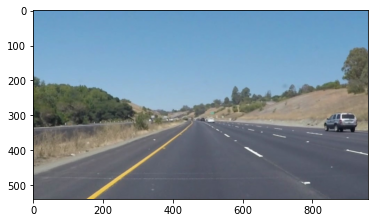

In [125]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

##### cv2.inRange() for color selection
##### cv2.fillPoly() for regions selection
##### cv2.line() to draw lines on an image given endpoints
##### cv2.addWeighted() to coadd / overlay two images
##### cv2.cvtColor() to grayscale or change color
##### cv2.imwrite() to output images to file
##### cv2.bitwise_and() to apply a mask to an image

### Functions

In [126]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 255, 0], thickness=8):
   
    if lines is None:
        return img
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.4, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


In [127]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

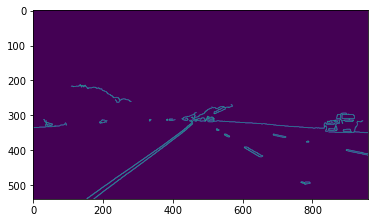

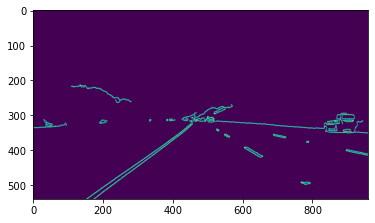

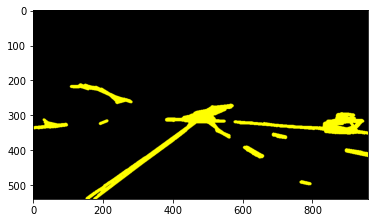

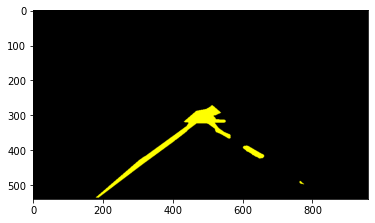

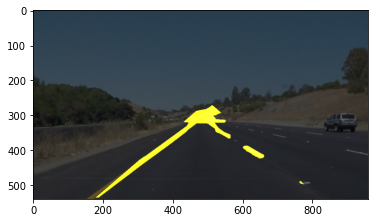

In [128]:



# Convert image to gray scale
gray = grayscale(image)

# Blur the image
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size=kernel_size)

#Canny edge
low_threshold = 40
high_threshold = 280
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges) 
plt.show()

img_dilation = cv2.dilate(edges, (5,5), iterations=1)
plt.imshow(img_dilation) 
plt.show()



#Hough Lines
rho = 3
theta = 1*np.pi/180
threshold = 20
min_line_length = 20
max_line_gap = 30
line_image = np.copy(image)*0 #creating a blank to draw lines on

line_image = hough_lines(img_dilation, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(line_image) 
plt.show()

# Region of interest
left_bottom = [180, 535]
right_bottom = [820, 535]
apex = [500, 260]
points = np.array([left_bottom, right_bottom, apex])

masked_image = region_of_interest(line_image,[points] )
plt.imshow(masked_image) 
plt.show()

# image_lines = cv2.bitwise_and(line_image,masked_image )
# plt.imshow(image_lines) 
# plt.show()

# Weighted Image
weighted_image = weighted_img(masked_image, image)
plt.imshow(weighted_image) 
plt.show()




In [129]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)


    

    # Convert image to gray scale
    gray = grayscale(image)

    # Blur the image
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size=kernel_size)

    #Canny edge
    low_threshold = 40
    high_threshold = 280
    edges = canny(blur_gray, low_threshold, high_threshold)

    img_dilation = cv2.dilate(edges, (5,5), iterations=1)

    #Hough Lines
    rho = 3
    theta = 1*np.pi/180
    threshold = 10
    min_line_length = 25
    max_line_gap = 28
    line_image = hough_lines(img_dilation, rho, theta, threshold, min_line_length, max_line_gap)

    # Region of interest
    left_bottom = [130, 539]
    right_bottom = [850, 539]
    apex = [500, 310]
    points = np.array([left_bottom, right_bottom, apex])

    masked_image = region_of_interest(line_image,[points] )

    

    # Weighted Image
    result = weighted_img(masked_image, image)

    return result

In [130]:
cap = cv2.VideoCapture("test_videos/solidYellowLeft.mp4")


# Get video metadata
video_fps = cap.get(cv2.CAP_PROP_FPS),
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

# we are using x264 codec for mp4
fourcc = cv2.VideoWriter_fourcc(*'X264')
writer = cv2.VideoWriter('OUTPUT_PATH_2.mp4', apiPreference=0, fourcc=fourcc,
                     fps=video_fps[0], frameSize=(int(width), int(height)))
i = 0

while True:
    ret, frame = cap.read()
    if not ret: break # break if cannot receive frame
    # convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    
    frame = process_image(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    writer.write(frame) # write frame
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # on press of q break
        break
        
# release and destroy windows
writer.release()
cap.release()
cv2.destroyAllWindows()